<a href="https://colab.research.google.com/github/akshatamadavi/cmpe258-assignment-3/blob/main/%5Bcolab_a%5D3Layer_Neural_Network_NonLinear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 3-Layer Deep Neural Network for Non-Linear Regression
### From Scratch — NumPy weights + `tf.einsum` (NO keras, NO autograd)

---
**Architecture:**
- Input Layer: 3 features (x1, x2, x3)
- Hidden Layer 1: 64 neurons — activation: `tanh`
- Hidden Layer 2: 32 neurons — activation: `ReLU`
- Hidden Layer 3: 16 neurons — activation: `ELU`
- Output Layer: 1 neuron — `Linear` (regression)

**Target Equation (3 variables):**
$$y = \sin(x_1)\cos(x_2) + x_3^2 e^{-x_1} + \ln(|x_2|+1)\cdot x_3$$

**Backprop:** Manual chain-rule gradient propagation  
**Matrix ops:** `tf.einsum` replaces all `matmul` / `@` calls


In [1]:
# Cell 1 — Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import warnings; warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)
print('NumPy:', np.__version__)
print('TensorFlow:', tf.__version__)


NumPy: 2.0.2
TensorFlow: 2.19.0


## 📊 Step 1 — Synthetic Data Generation
**Target:**  $y = \sin(x_1)\cos(x_2) + x_3^2 e^{-x_1} + \ln(|x_2|+1)\cdot x_3$


In [2]:
# Cell 2 — Generate synthetic data
N = 2000
x1 = np.random.uniform(-np.pi, np.pi, N)
x2 = np.random.uniform(-np.pi, np.pi, N)
x3 = np.random.uniform(-2.0,   2.0,  N)

y = (np.sin(x1) * np.cos(x2)
     + x3**2 * np.exp(-x1)
     + np.log(np.abs(x2) + 1) * x3)
y += 0.05 * np.random.randn(N)  # small noise

X = np.column_stack([x1, x2, x3])  # (N, 3)
y = y.reshape(-1, 1)               # (N, 1)
print(f'X shape: {X.shape}, y shape: {y.shape}')
print(f'y range: [{y.min():.3f}, {y.max():.3f}]  mean={y.mean():.3f}  std={y.std():.3f}')


X shape: (2000, 3), y shape: (2000, 1)
y range: [-2.990, 86.212]  mean=5.232  std=11.200


In [3]:
# Cell 3 — Normalise & train/test split
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()

X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std

split = int(0.8 * N)
idx   = np.random.permutation(N)
X_train, y_train = X_norm[idx[:split]], y_norm[idx[:split]]
X_test,  y_test  = X_norm[idx[split:]], y_norm[idx[split:]]
print(f'Train: {X_train.shape}   Test: {X_test.shape}')


Train: (1600, 3)   Test: (400, 3)


## 📈 Step 2 — 4D Visualisation using PCA (scikit-learn)
PCA reduces the 3 inputs → 2 principal components.  
Plot axes: PC1, PC2, y (3D scatter) with colour encoding y as the 4th dimension.


PCA explained variance: [0.3458614  0.33235369]  total=0.678


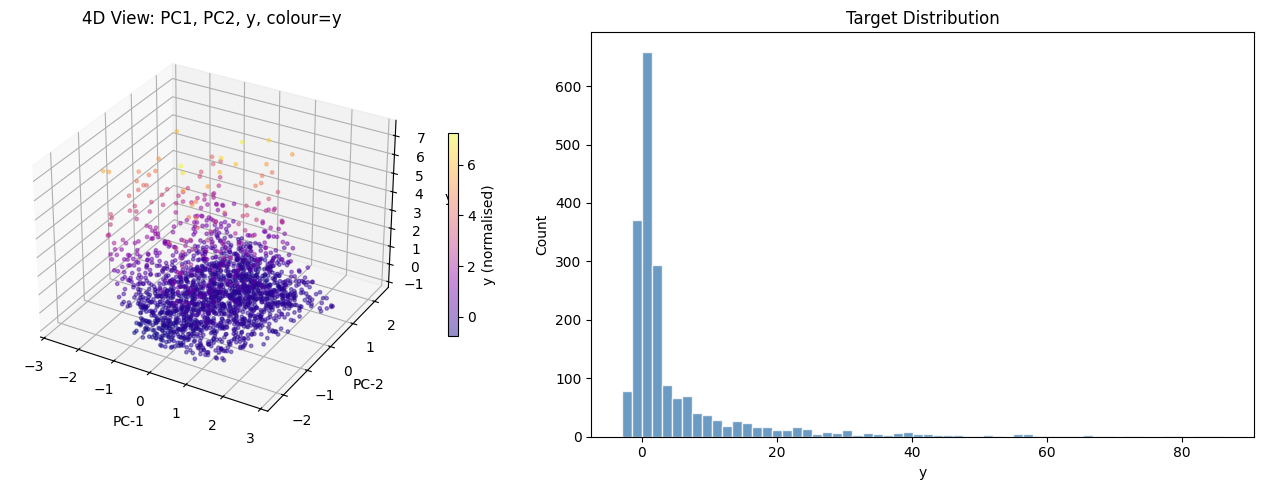

In [4]:
# Cell 4 — 4D plot via PCA
pca   = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
print(f'PCA explained variance: {pca.explained_variance_ratio_}  total={pca.explained_variance_ratio_.sum():.3f}')

fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(121, projection='3d')
sc  = ax1.scatter(X_pca[:,0], X_pca[:,1], y_norm.ravel(),
                  c=y_norm.ravel(), cmap='plasma', alpha=0.45, s=6)
fig.colorbar(sc, ax=ax1, shrink=0.5, label='y (normalised)')
ax1.set_xlabel('PC-1'); ax1.set_ylabel('PC-2'); ax1.set_zlabel('y')
ax1.set_title('4D View: PC1, PC2, y, colour=y')

ax2 = fig.add_subplot(122)
ax2.hist(y.ravel(), bins=60, color='steelblue', edgecolor='white', alpha=0.8)
ax2.set_xlabel('y'); ax2.set_ylabel('Count'); ax2.set_title('Target Distribution')
plt.tight_layout(); plt.show()


## 🏗️ Step 3 — Weight Initialisation & Activation Functions


In [5]:
# Cell 5 — Weight init
def he_init(fan_in, fan_out):
    return np.random.randn(fan_in, fan_out) * np.sqrt(2.0 / fan_in)

def xavier_init(fan_in, fan_out):
    return np.random.randn(fan_in, fan_out) * np.sqrt(1.0 / fan_in)

n_in, n_h1, n_h2, n_h3, n_out = 3, 64, 32, 16, 1

W1 = xavier_init(n_in, n_h1); b1 = np.zeros((1, n_h1))
W2 = he_init(n_h1, n_h2);     b2 = np.zeros((1, n_h2))
W3 = he_init(n_h2, n_h3);     b3 = np.zeros((1, n_h3))
W4 = he_init(n_h3, n_out);    b4 = np.zeros((1, n_out))

for name, W in [('W1',W1),('W2',W2),('W3',W3),('W4',W4)]:
    print(f'{name}: {W.shape}')


W1: (3, 64)
W2: (64, 32)
W3: (32, 16)
W4: (16, 1)


In [6]:
# Cell 6 — Activation functions and their derivatives
def tanh_f(z):      return np.tanh(z)
def tanh_d(a):      return 1.0 - a**2          # derivative uses activated value

def relu_f(z):      return np.maximum(0, z)
def relu_d(z):      return (z > 0).astype(float)

alpha_elu = 1.0
def elu_f(z):       return np.where(z >= 0, z, alpha_elu*(np.exp(z)-1))
def elu_d(z):       return np.where(z >= 0, 1.0, alpha_elu*np.exp(z))

print('Activations ready: tanh | ReLU | ELU | linear')


Activations ready: tanh | ReLU | ELU | linear


## ⚡ Step 4 — tf.einsum Helper (replaces ALL matmul)
`tf.einsum('ij,jk->ik', A, B)` is used for every linear transform in forward AND backward pass.


In [7]:
# Cell 7 — tf.einsum wrapper
def emm(A, B):
    '''
    Matrix multiply A(m,k) @ B(k,n) using tf.einsum.
    Inputs/outputs are NumPy. Only the multiply uses TensorFlow.
    '''
    A_tf = tf.constant(A, dtype=tf.float64)
    B_tf = tf.constant(B, dtype=tf.float64)
    return tf.einsum('ij,jk->ik', A_tf, B_tf).numpy()

# Sanity check
a = np.ones((3,4)); b = np.ones((4,5))*2
c = emm(a, b)
print(f'emm test: (3,4)@(4,5) -> {c.shape}, values={c[0,0]} (expected 8.0) OK')


emm test: (3,4)@(4,5) -> (3, 5), values=8.0 (expected 8.0) OK


## 🔄 Step 5 — Forward Pass


In [8]:
# Cell 8 — Forward pass
def forward(X, W1,b1, W2,b2, W3,b3, W4,b4):
    # Layer 1 — tanh
    Z1 = emm(X,  W1) + b1;  A1 = tanh_f(Z1)
    # Layer 2 — ReLU
    Z2 = emm(A1, W2) + b2;  A2 = relu_f(Z2)
    # Layer 3 — ELU
    Z3 = emm(A2, W3) + b3;  A3 = elu_f(Z3)
    # Output  — Linear
    Z4 = emm(A3, W4) + b4
    cache = (X, Z1, A1, Z2, A2, Z3, A3, Z4)
    return Z4, cache

y_hat_test, _ = forward(X_train[:5], W1,b1, W2,b2, W3,b3, W4,b4)
print(f'Forward pass OK — output shape: {y_hat_test.shape}')


Forward pass OK — output shape: (5, 1)


## 🔁 Step 6 — Backward Pass (Manual Chain Rule)

```
dL/dZ4  = (2/m)(y_hat - y)
dL/dW4  = A3.T @ dZ4          dL/db4 = sum(dZ4)
dL/dA3  = dZ4 @ W4.T
dL/dZ3  = dA3 * elu'(Z3)      dL/dW3 = A2.T @ dZ3
dL/dA2  = dZ3 @ W3.T
dL/dZ2  = dA2 * relu'(Z2)     dL/dW2 = A1.T @ dZ2
dL/dA1  = dZ2 @ W2.T
dL/dZ1  = dA1 * (1 - A1^2)   dL/dW1 = X.T  @ dZ1
```
All `@` ops above are implemented with `tf.einsum`.


In [9]:
# Cell 9 — Backward pass (manual backprop)
def backward(y, y_hat, cache, W1,W2,W3,W4):
    X, Z1, A1, Z2, A2, Z3, A3, Z4 = cache
    m = y.shape[0]

    # --- Output layer ---
    dZ4 = (2.0/m) * (y_hat - y)              # (m,1)
    dW4 = emm(A3.T, dZ4)                     # (16,1)
    db4 = np.sum(dZ4, axis=0, keepdims=True) # (1,1)

    # --- Layer 3: ELU ---
    dA3 = emm(dZ4, W4.T)                     # (m,16)
    dZ3 = dA3 * elu_d(Z3)                    # element-wise
    dW3 = emm(A2.T, dZ3)                     # (32,16)
    db3 = np.sum(dZ3, axis=0, keepdims=True) # (1,16)

    # --- Layer 2: ReLU ---
    dA2 = emm(dZ3, W3.T)                     # (m,32)
    dZ2 = dA2 * relu_d(Z2)                   # element-wise
    dW2 = emm(A1.T, dZ2)                     # (64,32)
    db2 = np.sum(dZ2, axis=0, keepdims=True) # (1,32)

    # --- Layer 1: tanh ---
    dA1 = emm(dZ2, W2.T)                     # (m,64)
    dZ1 = dA1 * tanh_d(A1)                  # uses activated value A1
    dW1 = emm(X.T,  dZ1)                    # (3,64)
    db1 = np.sum(dZ1, axis=0, keepdims=True) # (1,64)

    return {'dW1':dW1,'db1':db1,'dW2':dW2,'db2':db2,
            'dW3':dW3,'db3':db3,'dW4':dW4,'db4':db4}

print('Backward pass function ready')


Backward pass function ready


## 🎯 Step 7 — Training Loop (Mini-batch SGD + Momentum)


In [10]:
# Cell 10 — Hyperparameters & momentum buffers
EPOCHS     = 500
BATCH_SIZE = 128
LR         = 0.005
MOM        = 0.9
LOG_EVERY  = 50

vel = {k: np.zeros_like(v) for k,v in
       [('W1',W1),('b1',b1),('W2',W2),('b2',b2),
        ('W3',W3),('b3',b3),('W4',W4),('b4',b4)]}

train_losses, test_losses = [], []
print(f'Training: epochs={EPOCHS}  batch={BATCH_SIZE}  lr={LR}  momentum={MOM}')


Training: epochs=500  batch=128  lr=0.005  momentum=0.9


In [11]:
# Cell 11 — Training loop
m_train = X_train.shape[0]

for epoch in range(1, EPOCHS+1):
    perm = np.random.permutation(m_train)
    Xs, ys = X_train[perm], y_train[perm]
    epoch_loss, n_batches = 0.0, 0

    for start in range(0, m_train, BATCH_SIZE):
        Xb = Xs[start:start+BATCH_SIZE]
        yb = ys[start:start+BATCH_SIZE]

        y_hat, cache = forward(Xb, W1,b1, W2,b2, W3,b3, W4,b4)
        loss = np.mean((y_hat - yb)**2)
        epoch_loss += loss;  n_batches += 1

        grads = backward(yb, y_hat, cache, W1,W2,W3,W4)

        # SGD + Momentum update
        for name, param in [('W1',W1),('b1',b1),('W2',W2),('b2',b2),
                             ('W3',W3),('b3',b3),('W4',W4),('b4',b4)]:
            vel[name] = MOM*vel[name] - LR*grads['d'+name]
            param    += vel[name]     # in-place update

    avg_tr = epoch_loss / n_batches
    y_pred_te, _ = forward(X_test, W1,b1, W2,b2, W3,b3, W4,b4)
    te_loss = np.mean((y_pred_te - y_test)**2)
    train_losses.append(avg_tr);  test_losses.append(te_loss)

    if epoch % LOG_EVERY == 0 or epoch == 1:
        print(f'Epoch [{epoch:4d}/{EPOCHS}]  Train MSE={avg_tr:.6f}   Test MSE={te_loss:.6f}')

print('Training complete!')


Epoch [   1/500]  Train MSE=0.965268   Test MSE=0.730321
Epoch [  50/500]  Train MSE=0.016186   Test MSE=0.015508
Epoch [ 100/500]  Train MSE=0.005755   Test MSE=0.007086
Epoch [ 150/500]  Train MSE=0.003341   Test MSE=0.003678
Epoch [ 200/500]  Train MSE=0.002816   Test MSE=0.003206
Epoch [ 250/500]  Train MSE=0.001812   Test MSE=0.002560
Epoch [ 300/500]  Train MSE=0.001832   Test MSE=0.002196
Epoch [ 350/500]  Train MSE=0.001494   Test MSE=0.002261
Epoch [ 400/500]  Train MSE=0.001426   Test MSE=0.002249
Epoch [ 450/500]  Train MSE=0.001257   Test MSE=0.002002
Epoch [ 500/500]  Train MSE=0.001081   Test MSE=0.001845
Training complete!


## 📉 Step 8 — Loss Curves


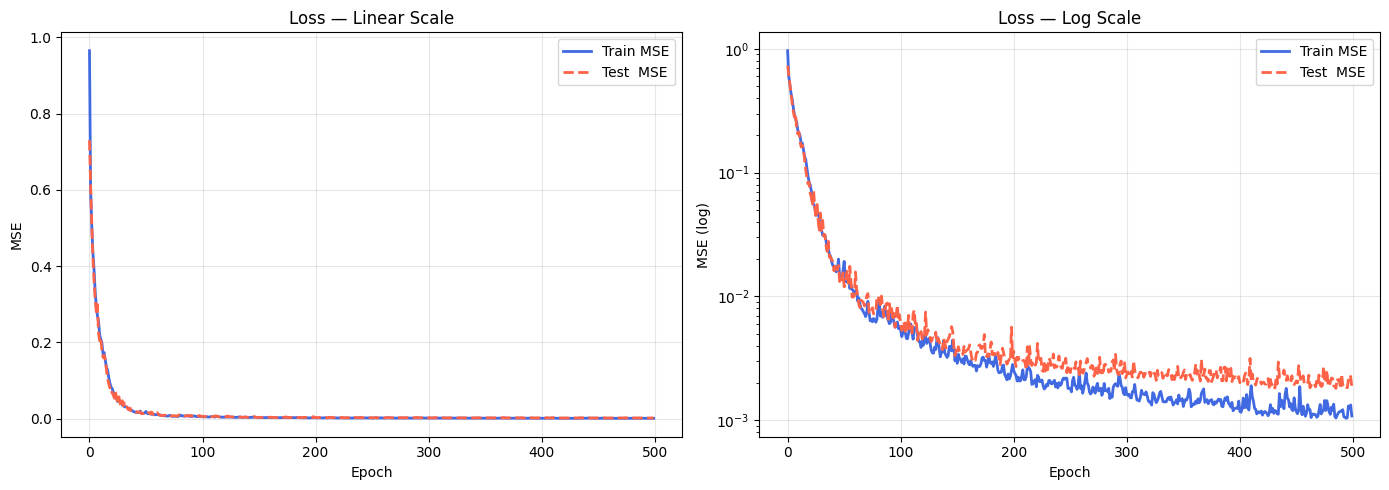

Final Train MSE: 0.001081
Final Test  MSE: 0.001845
Final Test RMSE: 0.042958


In [12]:
# Cell 12 — Plot loss curves
fig, axes = plt.subplots(1,2,figsize=(14,5))

axes[0].plot(train_losses, label='Train MSE', color='royalblue', lw=2)
axes[0].plot(test_losses,  label='Test  MSE', color='tomato', lw=2, ls='--')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE')
axes[0].set_title('Loss — Linear Scale'); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].semilogy(train_losses, label='Train MSE', color='royalblue', lw=2)
axes[1].semilogy(test_losses,  label='Test  MSE', color='tomato', lw=2, ls='--')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('MSE (log)')
axes[1].set_title('Loss — Log Scale'); axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout(); plt.show()
print(f'Final Train MSE: {train_losses[-1]:.6f}')
print(f'Final Test  MSE: {test_losses[-1]:.6f}')
print(f'Final Test RMSE: {np.sqrt(test_losses[-1]):.6f}')


## 🔍 Step 9 — Predictions vs Ground Truth


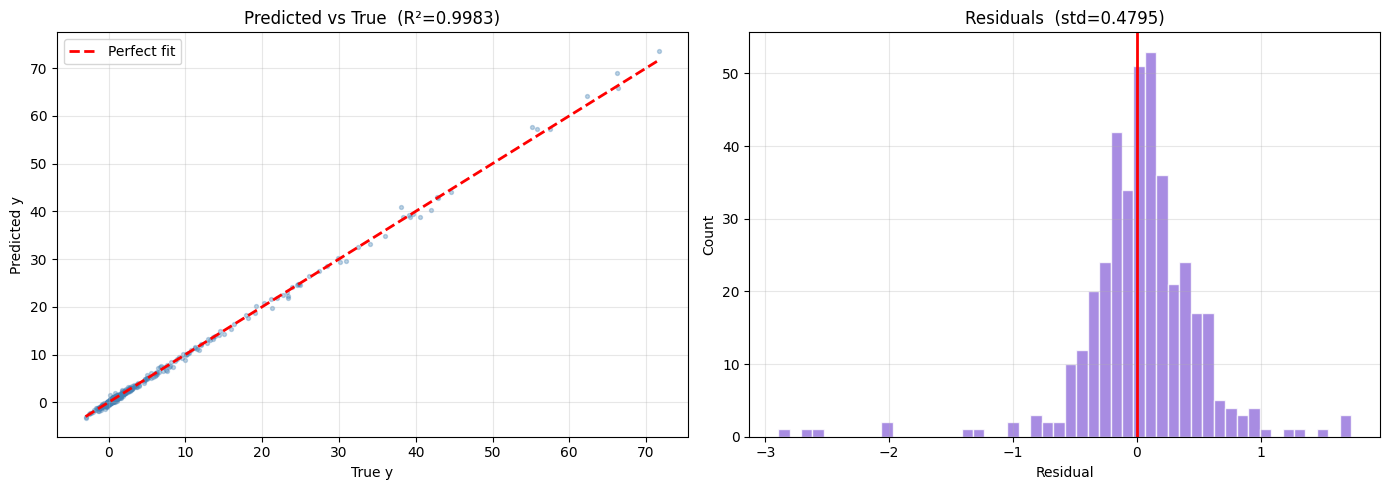

R2=0.998291  RMSE=0.481148  MAE=0.314673


In [13]:
# Cell 13 — Predicted vs True + residuals
y_pred, _ = forward(X_test, W1,b1, W2,b2, W3,b3, W4,b4)
y_pred_orig = y_pred * y_std + y_mean
y_true_orig = y_test * y_std + y_mean

ss_res = np.sum((y_true_orig - y_pred_orig)**2)
ss_tot = np.sum((y_true_orig - y_true_orig.mean())**2)
r2 = 1 - ss_res/ss_tot
residuals = (y_true_orig - y_pred_orig).ravel()

fig, axes = plt.subplots(1,2,figsize=(14,5))

axes[0].scatter(y_true_orig, y_pred_orig, alpha=0.35, s=8, color='steelblue')
mn,mx = y_true_orig.min(), y_true_orig.max()
axes[0].plot([mn,mx],[mn,mx],'r--',lw=2,label='Perfect fit')
axes[0].set_xlabel('True y'); axes[0].set_ylabel('Predicted y')
axes[0].set_title(f'Predicted vs True  (R²={r2:.4f})')
axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].hist(residuals, bins=50, color='mediumpurple', edgecolor='white', alpha=0.8)
axes[1].axvline(0, color='red', lw=2)
axes[1].set_xlabel('Residual'); axes[1].set_ylabel('Count')
axes[1].set_title(f'Residuals  (std={residuals.std():.4f})')
axes[1].grid(alpha=0.3)

plt.tight_layout(); plt.show()
print(f'R2={r2:.6f}  RMSE={np.sqrt(np.mean(residuals**2)):.6f}  MAE={np.mean(np.abs(residuals)):.6f}')


## 🌐 Step 10 — 4D Comparison: True vs Predicted vs Error (PCA)


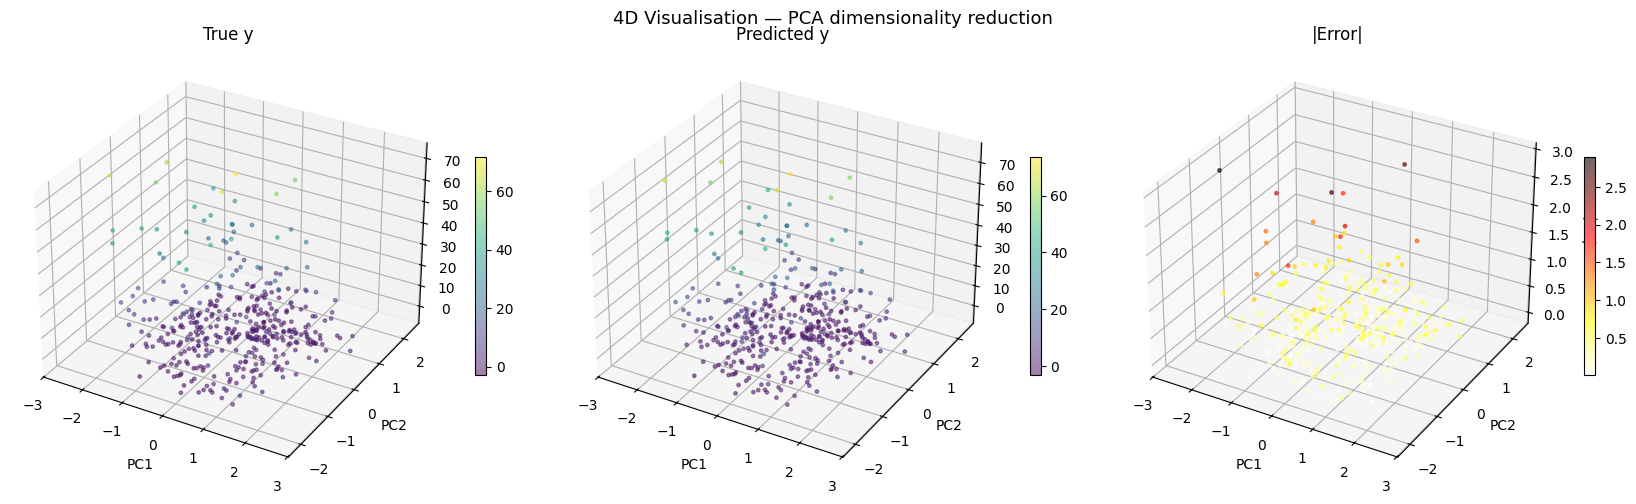

In [14]:
# Cell 14 — 4D comparison plots
X_test_pca = pca.transform(X_test)

fig = plt.figure(figsize=(17,5))

ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X_test_pca[:,0], X_test_pca[:,1], y_true_orig.ravel(),
                  c=y_true_orig.ravel(), cmap='viridis', s=6, alpha=0.5)
fig.colorbar(sc1, ax=ax1, shrink=0.5); ax1.set_title('True y')
ax1.set_xlabel('PC1'); ax1.set_ylabel('PC2'); ax1.set_zlabel('y')

ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(X_test_pca[:,0], X_test_pca[:,1], y_pred_orig.ravel(),
                  c=y_pred_orig.ravel(), cmap='viridis', s=6, alpha=0.5)
fig.colorbar(sc2, ax=ax2, shrink=0.5); ax2.set_title('Predicted y')
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2'); ax2.set_zlabel('y')

errors = np.abs(y_true_orig - y_pred_orig).ravel()
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(X_test_pca[:,0], X_test_pca[:,1], errors,
                  c=errors, cmap='hot_r', s=6, alpha=0.6)
fig.colorbar(sc3, ax=ax3, shrink=0.5); ax3.set_title('|Error|')
ax3.set_xlabel('PC1'); ax3.set_ylabel('PC2'); ax3.set_zlabel('|err|')

plt.suptitle('4D Visualisation — PCA dimensionality reduction', fontsize=13)
plt.tight_layout(); plt.show()


## 📋 Step 11 — Final Summary


In [15]:
# Cell 15 — Model summary
total = sum(np.prod(w.shape) for w in [W1,b1,W2,b2,W3,b3,W4,b4])
print('='*62)
print('  3-LAYER DEEP NEURAL NETWORK  —  FINAL SUMMARY')
print('='*62)
print('Target: y = sin(x1)cos(x2) + x3^2*exp(-x1) + ln(|x2|+1)*x3')
print()
print('Architecture:  Input(3) -> H1(64,tanh) -> H2(32,ReLU)')
print('                        -> H3(16,ELU)  -> Output(1,linear)')
print()
print('Matrix ops:    tf.einsum("ij,jk->ik") — no matmul/@')
print('Optimiser:     Mini-batch SGD + Momentum')
print(f'LR={LR}   Momentum={MOM}   Batch={BATCH_SIZE}   Epochs={EPOCHS}')
print()
for nm,W,b in [('1',W1,b1),('2',W2,b2),('3',W3,b3),('4',W4,b4)]:
    p = np.prod(W.shape)+np.prod(b.shape)
    print(f'  Layer {nm}: W{nm}{W.shape} + b{nm}{b.shape} = {p} params')
print(f'  TOTAL PARAMS: {int(total)}')
print()
print(f'  Final Train MSE : {train_losses[-1]:.6f}')
print(f'  Final Test  MSE : {test_losses[-1]:.6f}')
print(f'  Final Test RMSE : {np.sqrt(test_losses[-1]):.6f}')
print(f'  Final R²        : {r2:.6f}')
print('='*62)


  3-LAYER DEEP NEURAL NETWORK  —  FINAL SUMMARY
Target: y = sin(x1)cos(x2) + x3^2*exp(-x1) + ln(|x2|+1)*x3

Architecture:  Input(3) -> H1(64,tanh) -> H2(32,ReLU)
                        -> H3(16,ELU)  -> Output(1,linear)

Matrix ops:    tf.einsum("ij,jk->ik") — no matmul/@
Optimiser:     Mini-batch SGD + Momentum
LR=0.005   Momentum=0.9   Batch=128   Epochs=500

  Layer 1: W1(3, 64) + b1(1, 64) = 256 params
  Layer 2: W2(64, 32) + b2(1, 32) = 2080 params
  Layer 3: W3(32, 16) + b3(1, 16) = 528 params
  Layer 4: W4(16, 1) + b4(1, 1) = 17 params
  TOTAL PARAMS: 2881

  Final Train MSE : 0.001081
  Final Test  MSE : 0.001845
  Final Test RMSE : 0.042958
  Final R²        : 0.998291
